In [8]:
import pandas as pd
import numpy as np
import os
import glob
import tempfile
import shutil

import MDAnalysis
from MDAnalysis.analysis.hydrogenbonds import HydrogenBondAnalysis as HBA
from MDAnalysis.coordinates.memory import MemoryReader
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kruskal

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

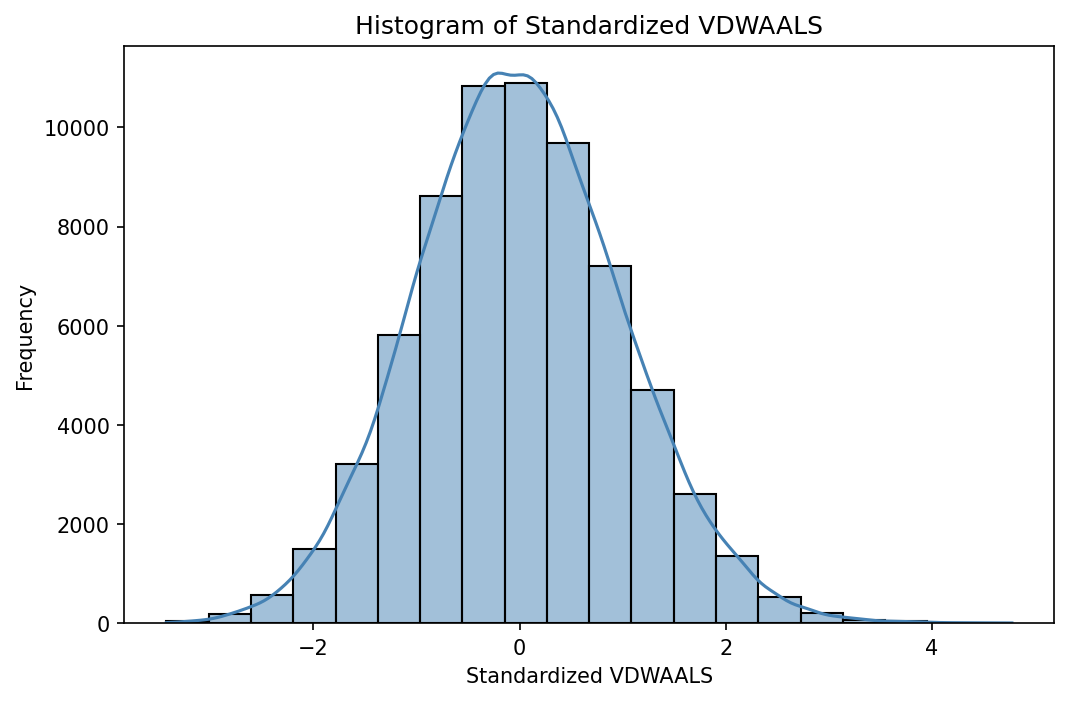

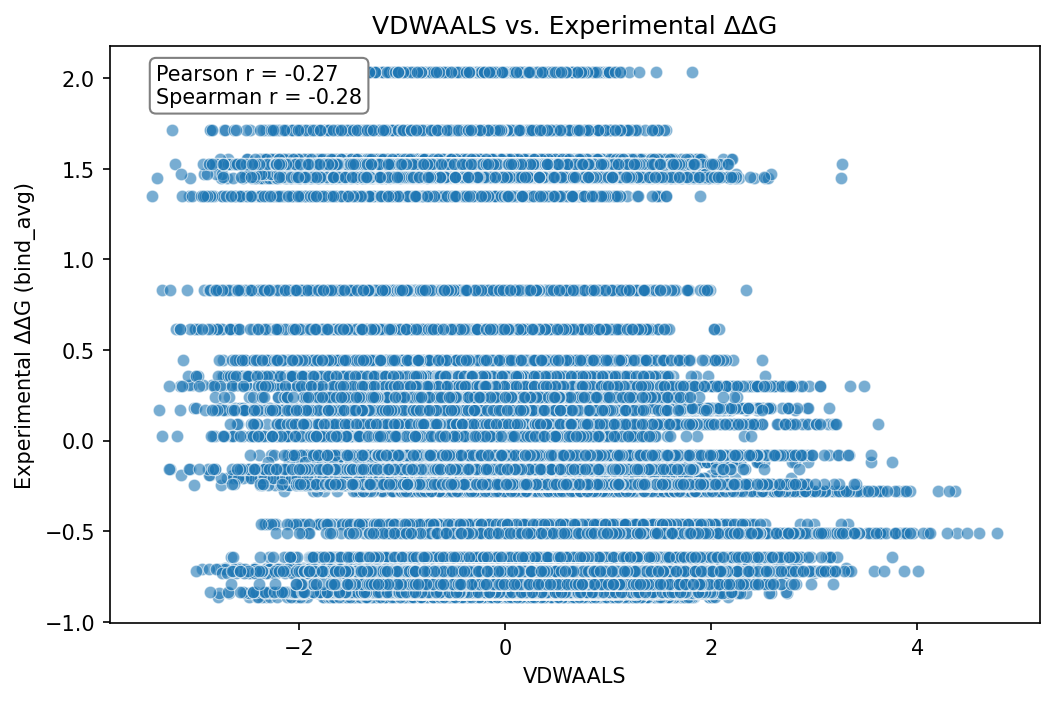

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


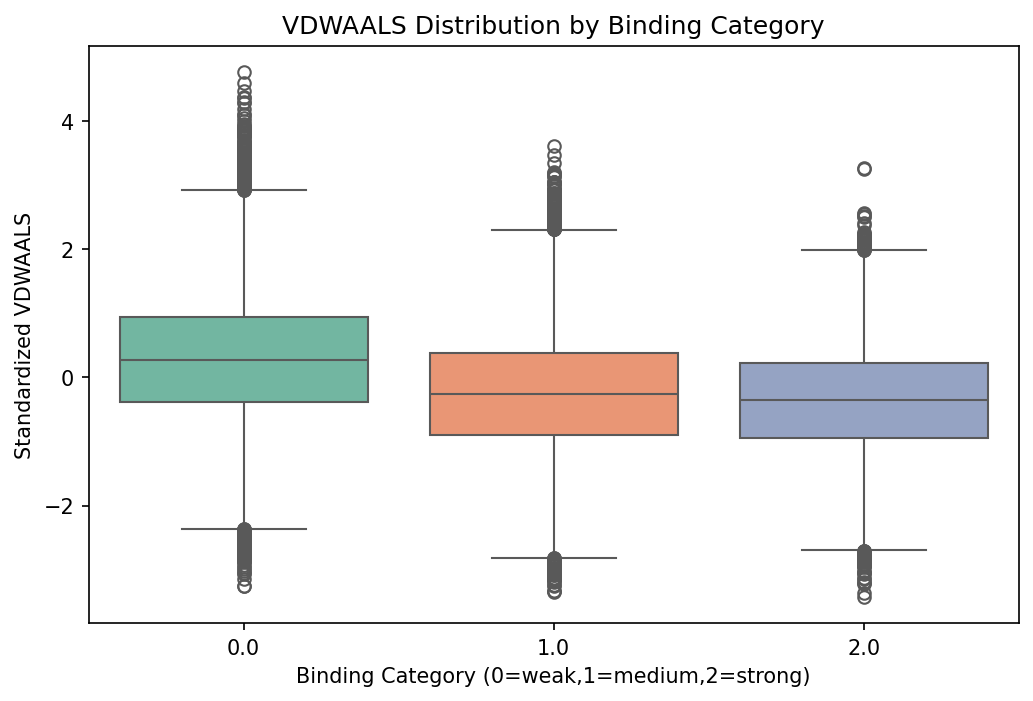

Term: VDWAALS
 • Avg. bootstrapped KW p-value: 8.554e-17
 • Full KW H-stat=5776.64, p-value=0.000e+00, η²=0.085
--------------------------------------------------


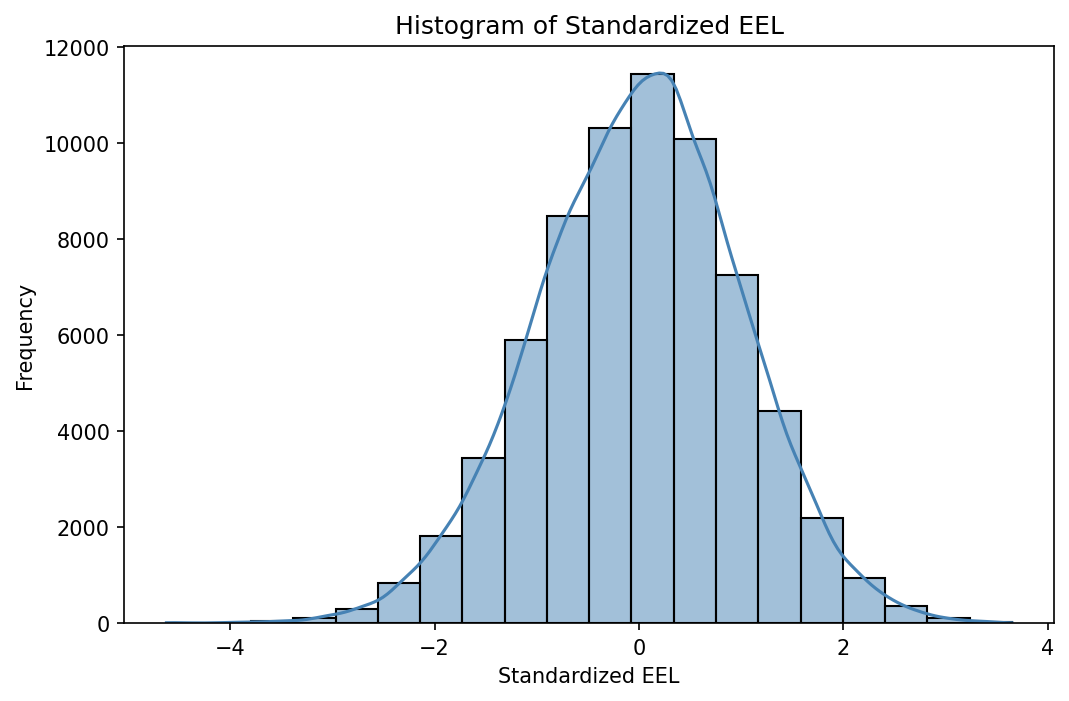

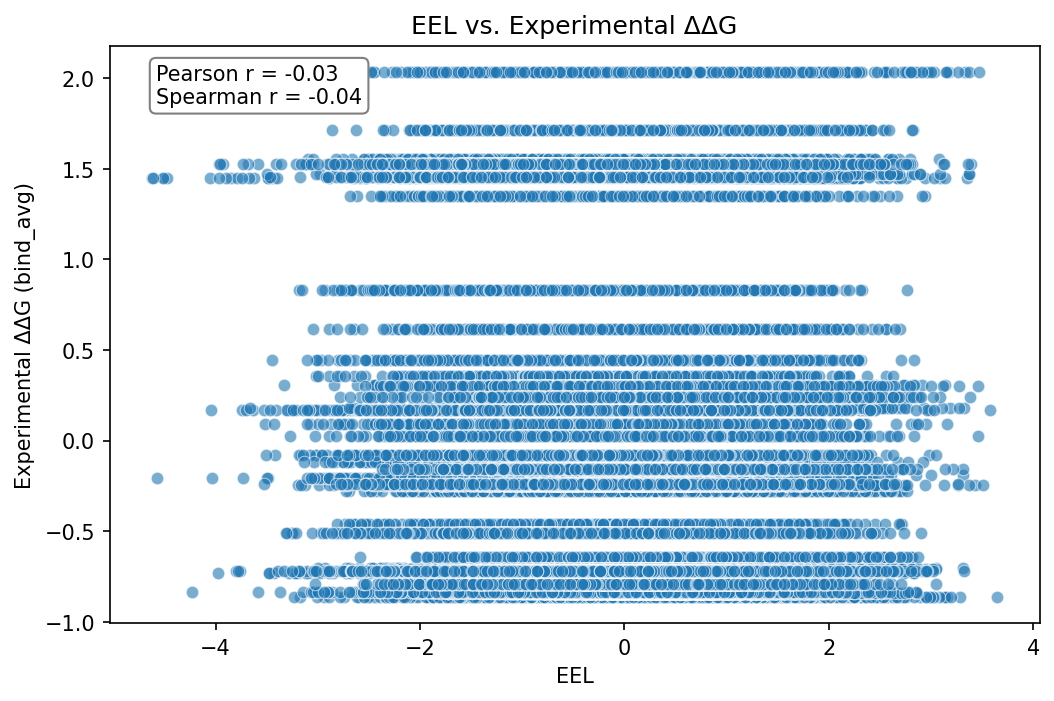

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


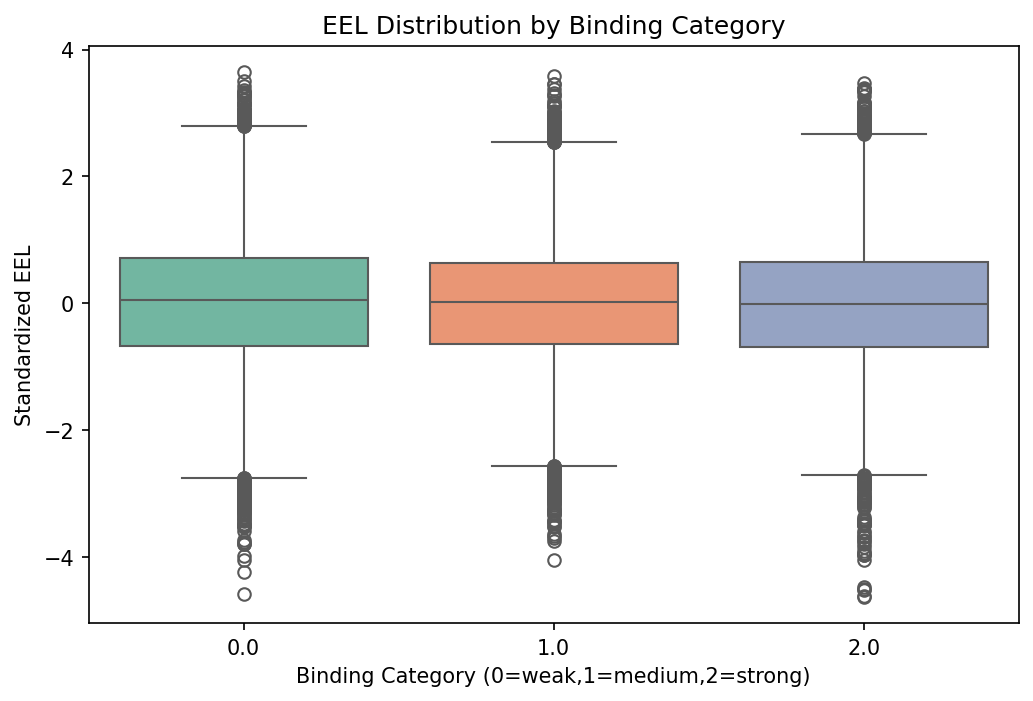

Term: EEL
 • Avg. bootstrapped KW p-value: 4.291e-01
 • Full KW H-stat=30.47, p-value=2.424e-07, η²=0.000
--------------------------------------------------


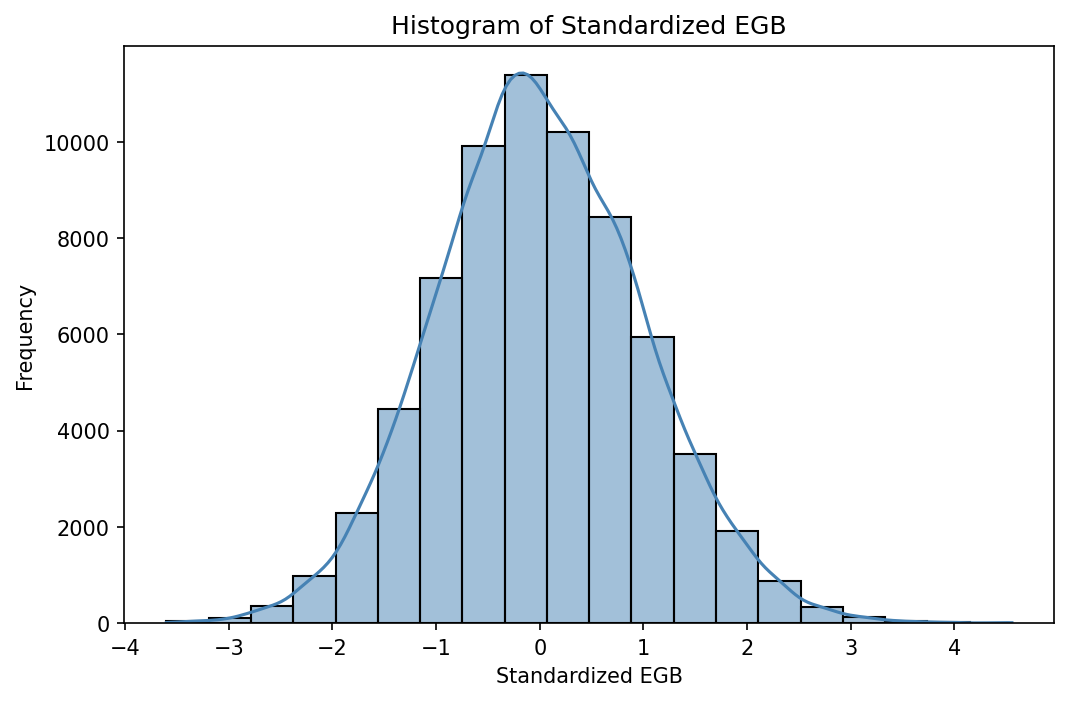

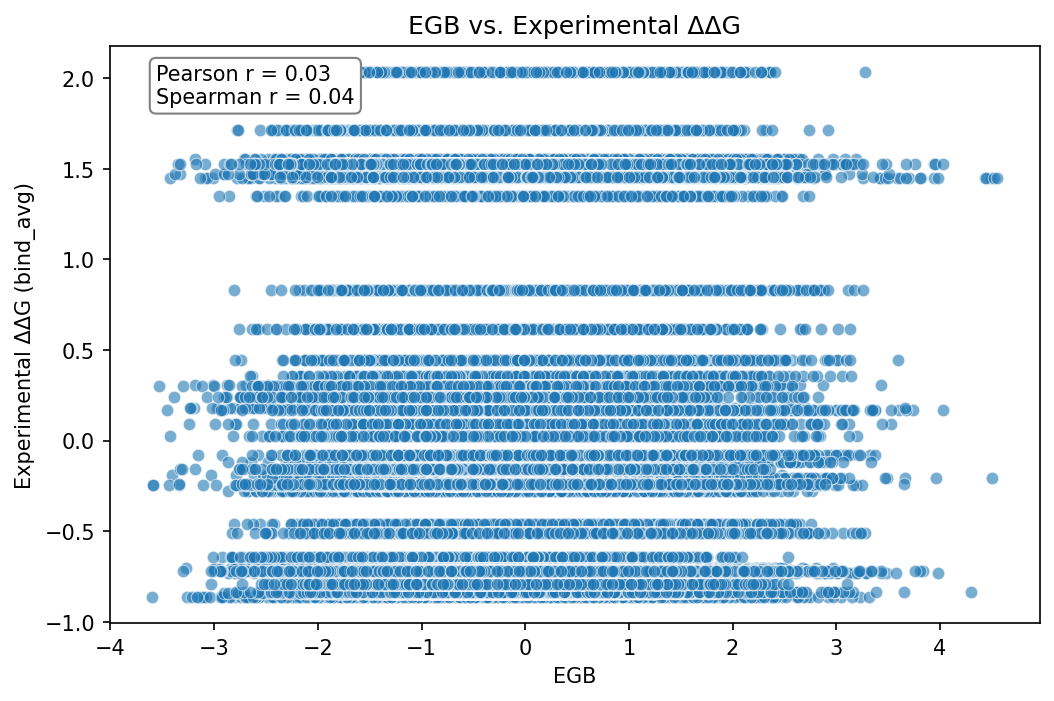

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


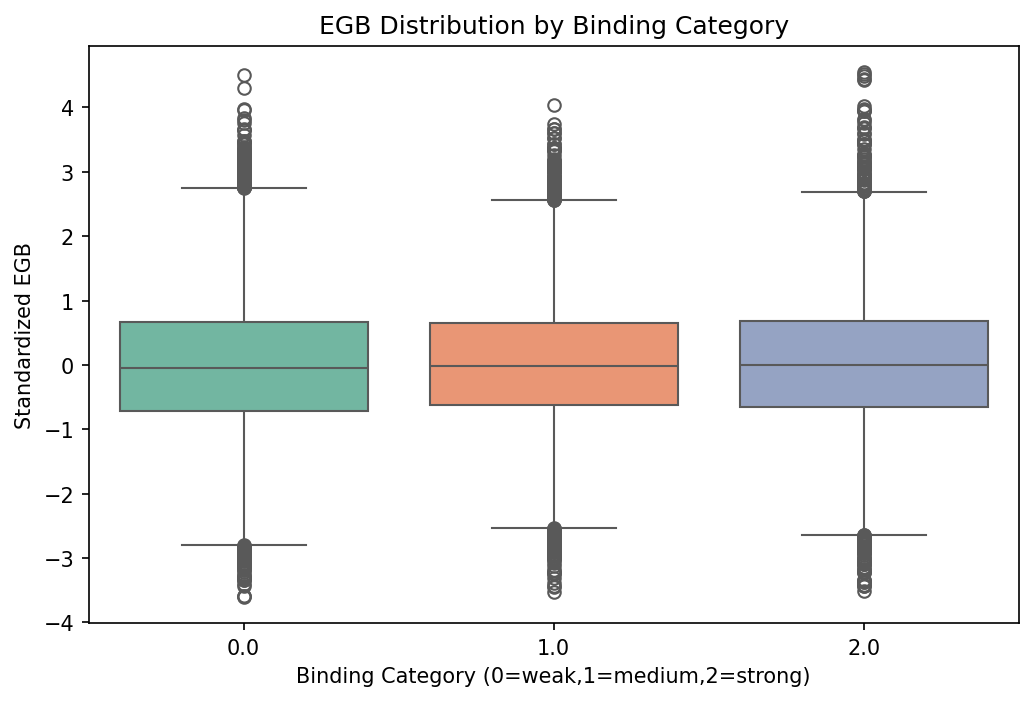

Term: EGB
 • Avg. bootstrapped KW p-value: 4.243e-01
 • Full KW H-stat=34.39, p-value=3.406e-08, η²=0.000
--------------------------------------------------


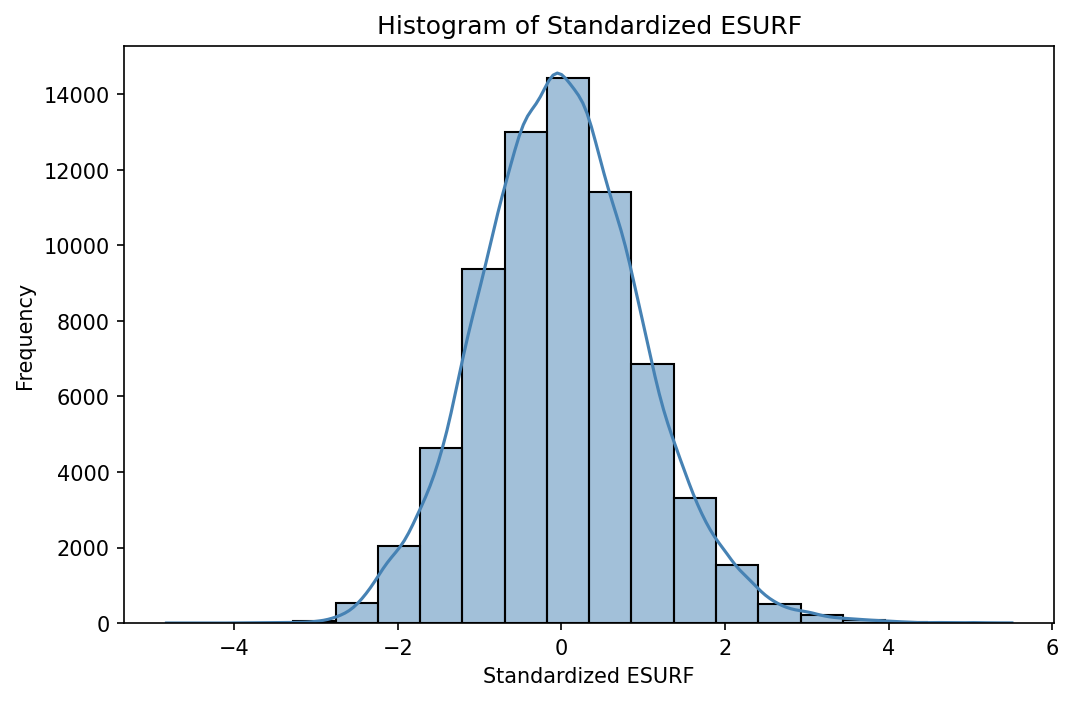

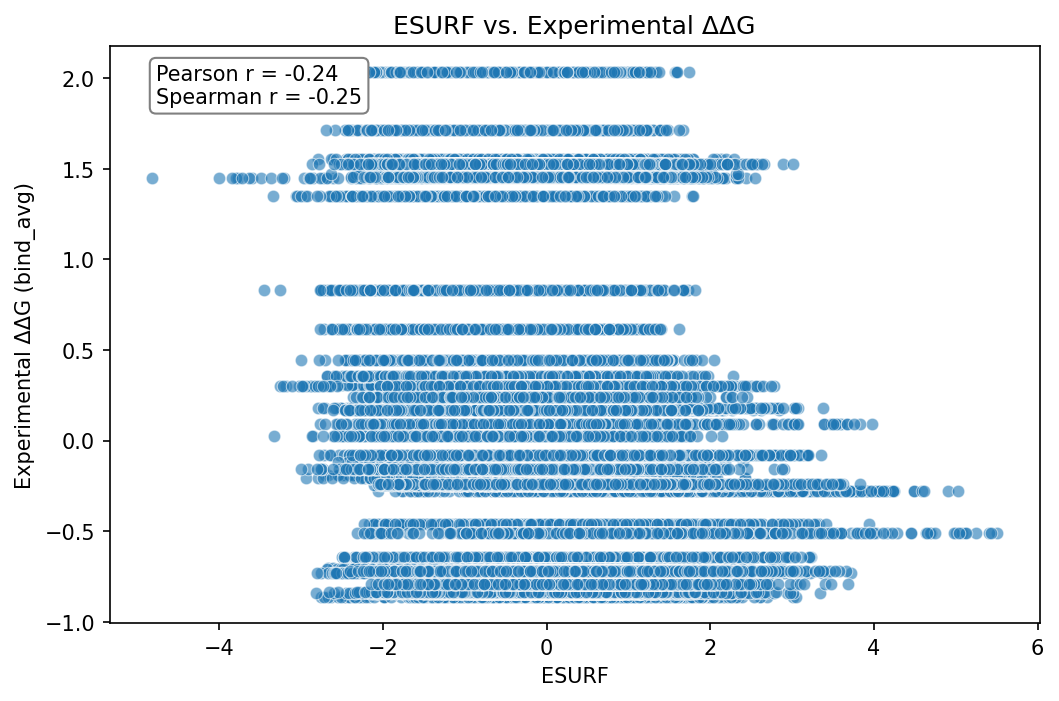

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


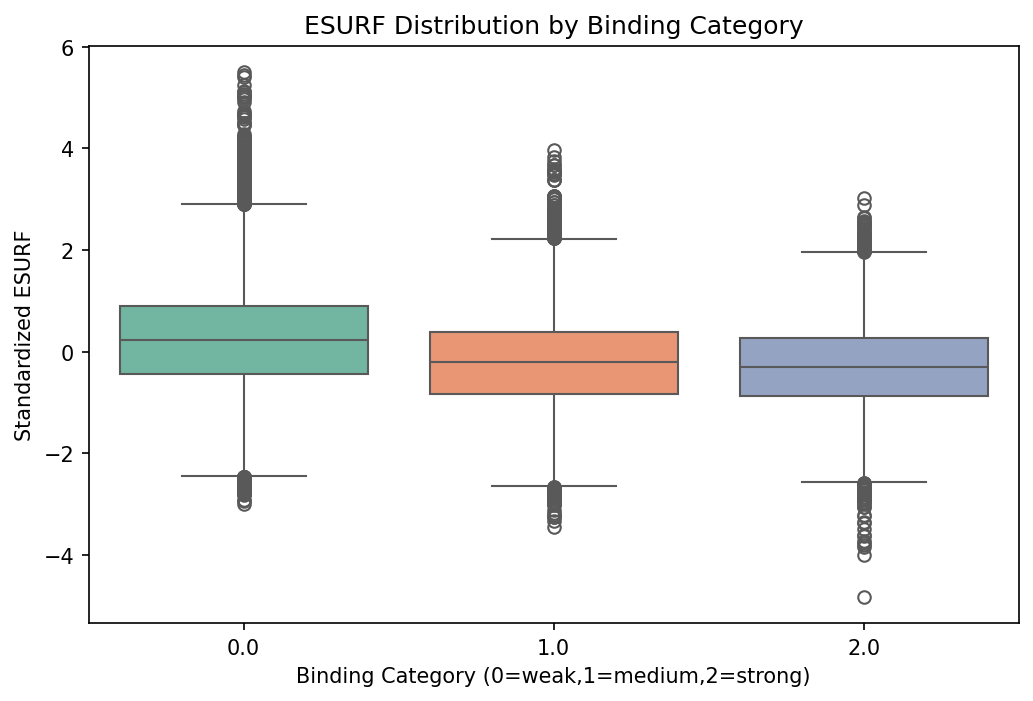

Term: ESURF
 • Avg. bootstrapped KW p-value: 4.134e-14
 • Full KW H-stat=4082.53, p-value=0.000e+00, η²=0.060
--------------------------------------------------


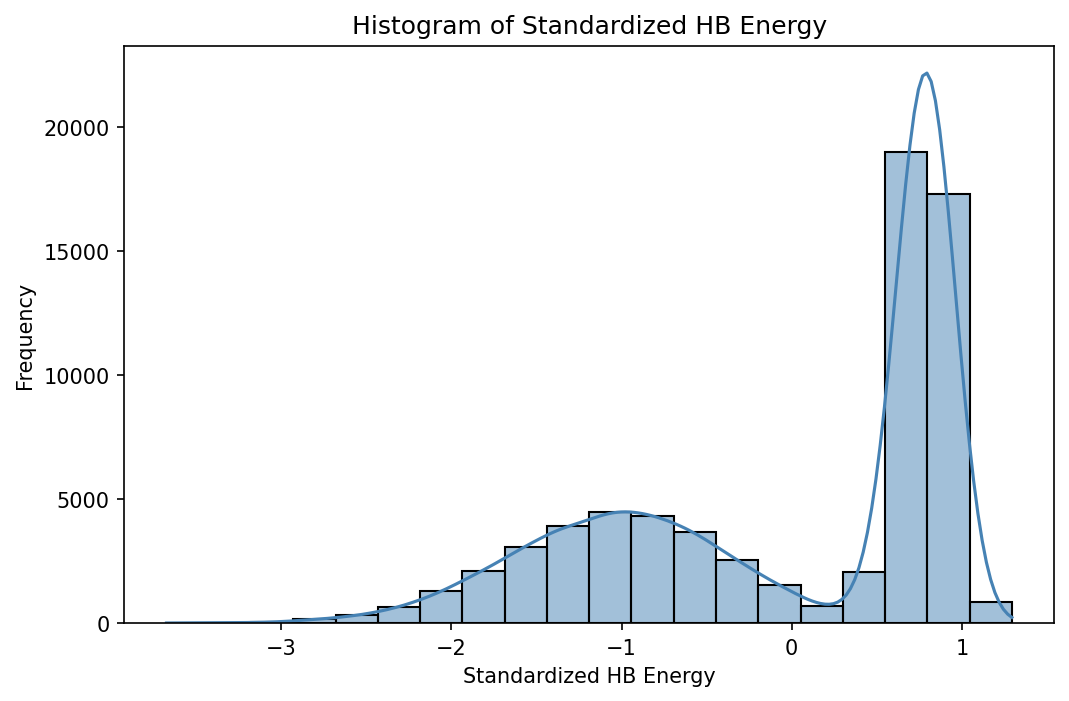

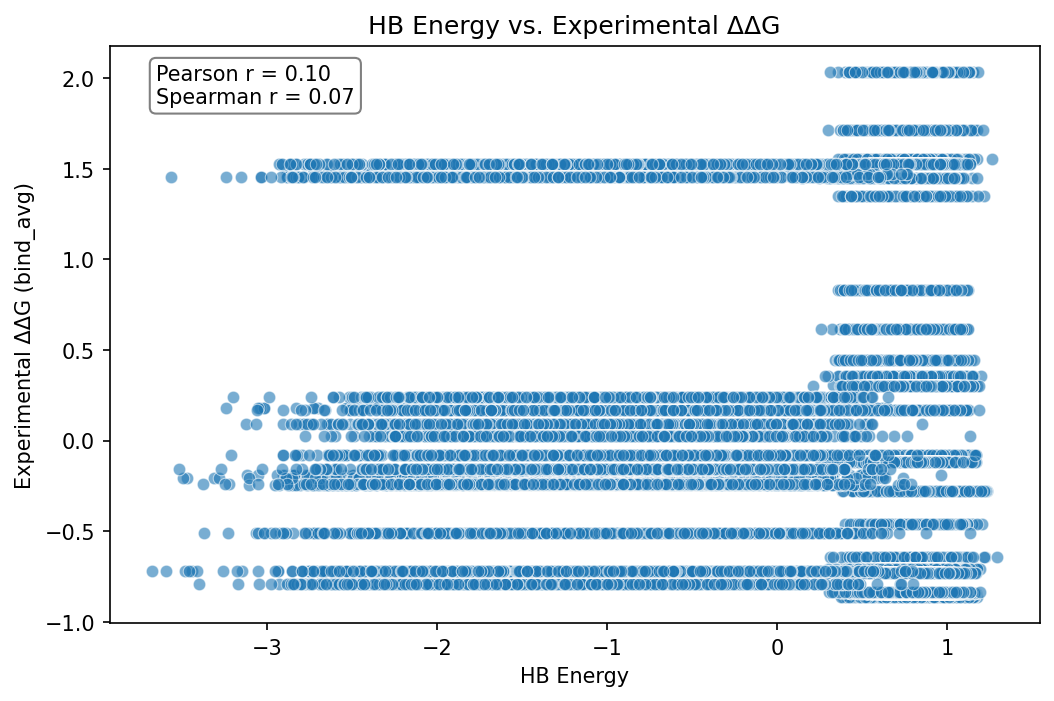

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


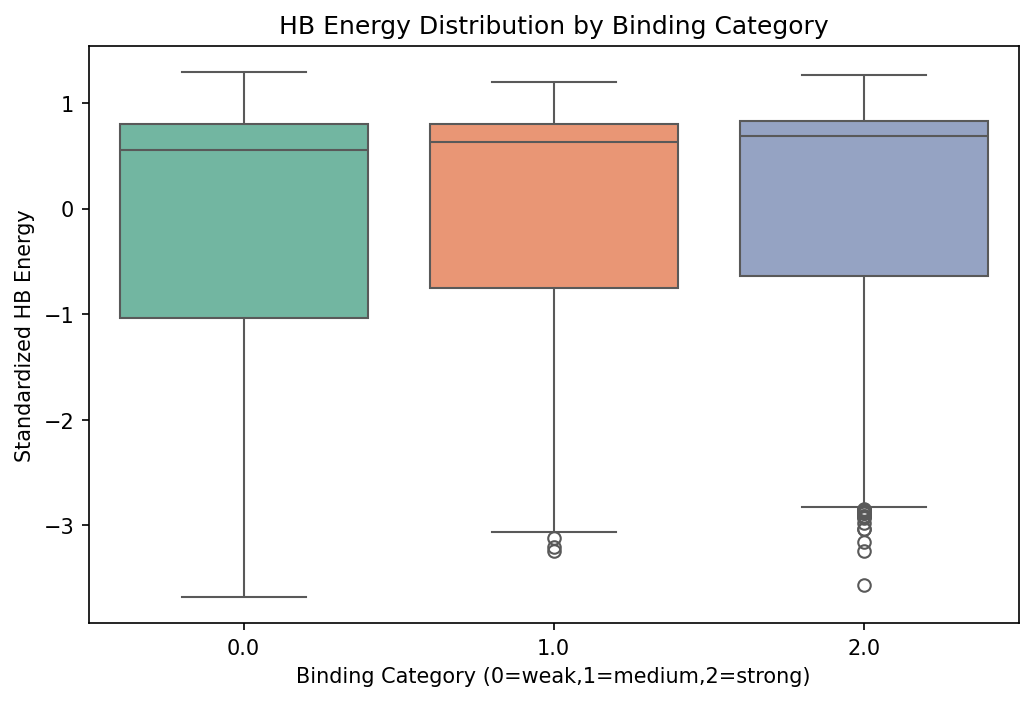

Term: HB Energy
 • Avg. bootstrapped KW p-value: 2.502e-02
 • Full KW H-stat=518.45, p-value=2.624e-113, η²=0.008
--------------------------------------------------


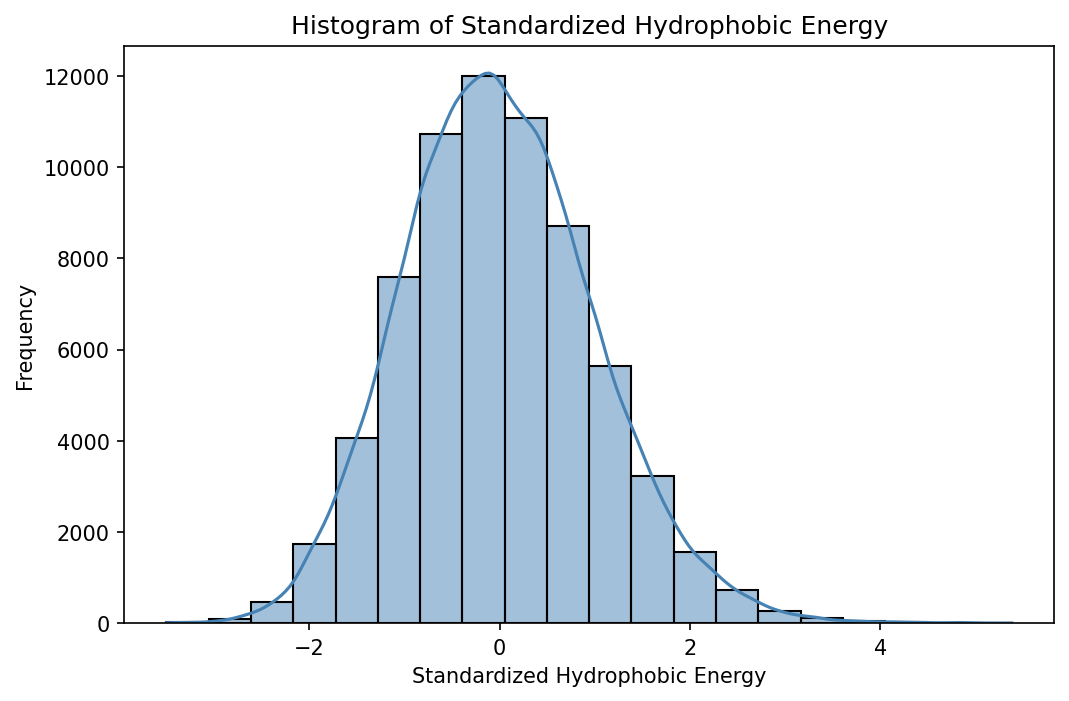

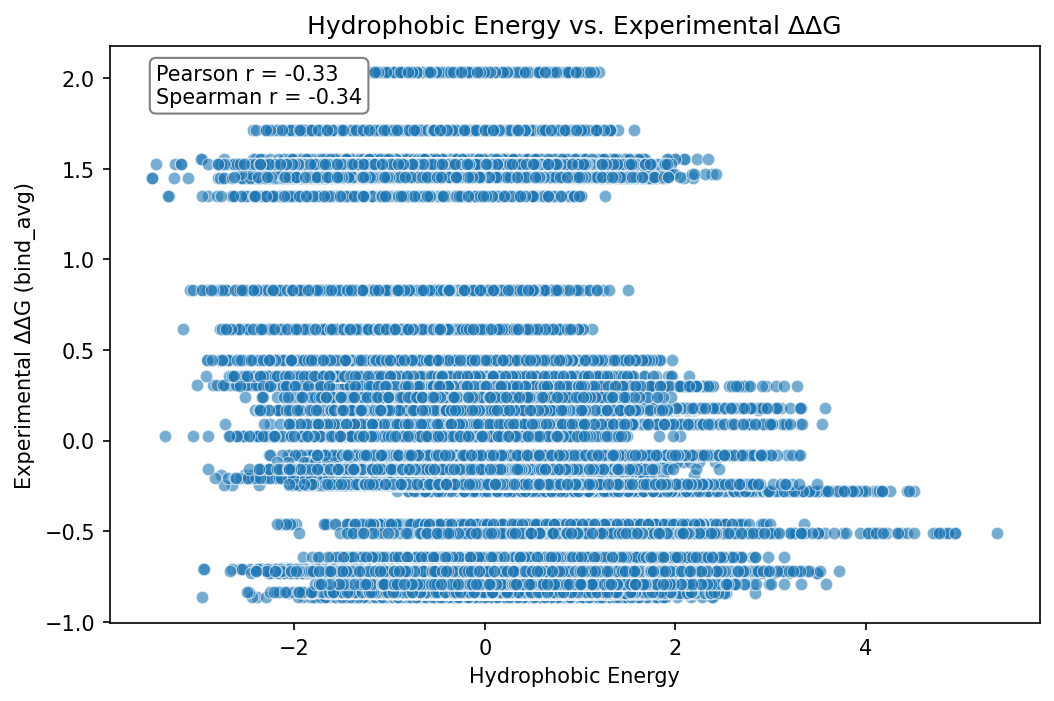

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


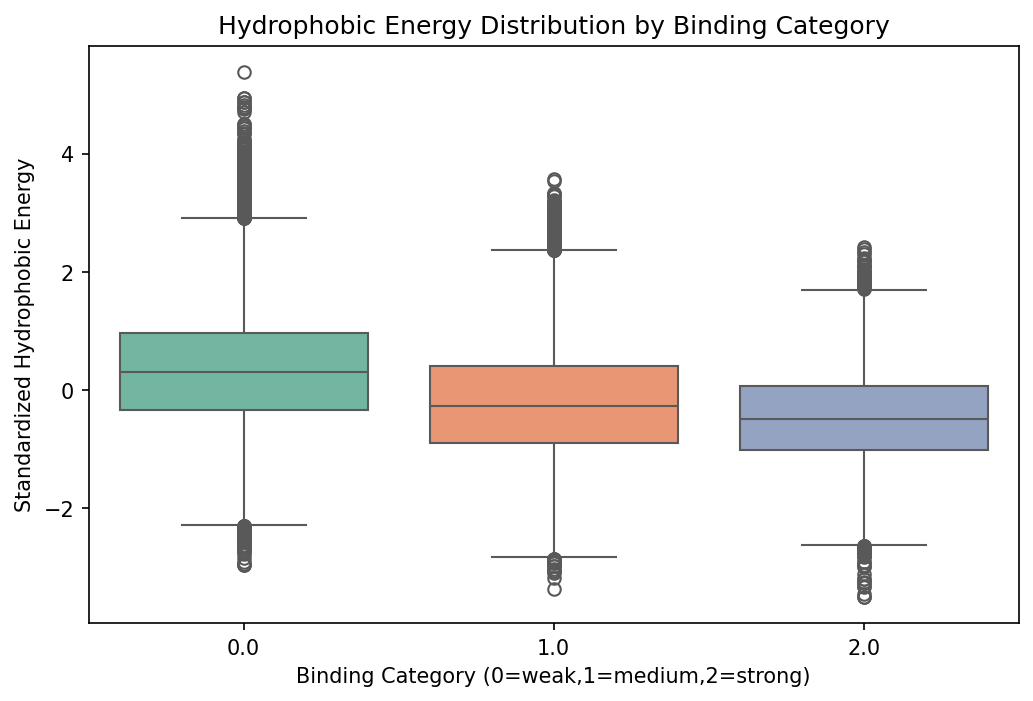

Term: Hydrophobic Energy
 • Avg. bootstrapped KW p-value: 1.207e-25
 • Full KW H-stat=7851.43, p-value=0.000e+00, η²=0.115
--------------------------------------------------


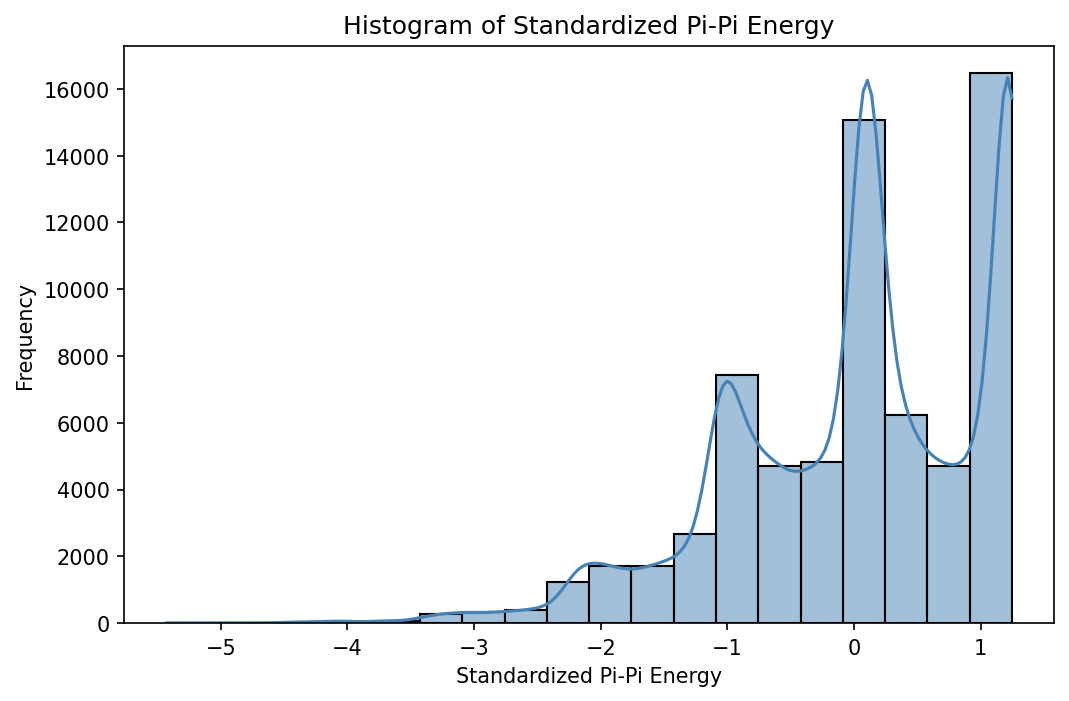

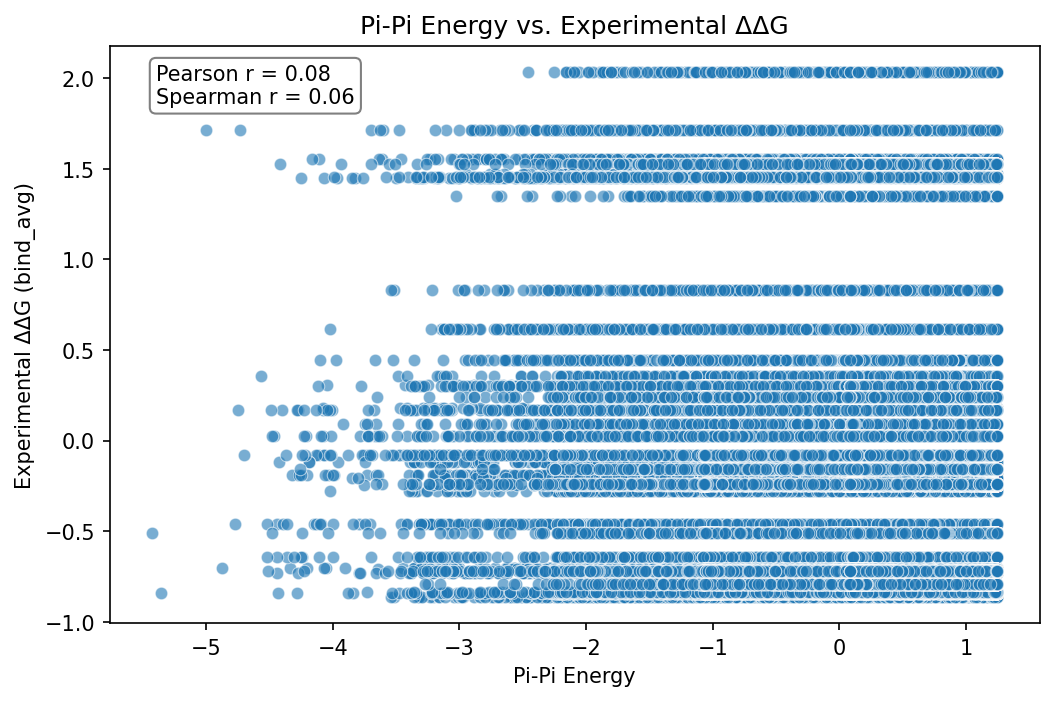

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


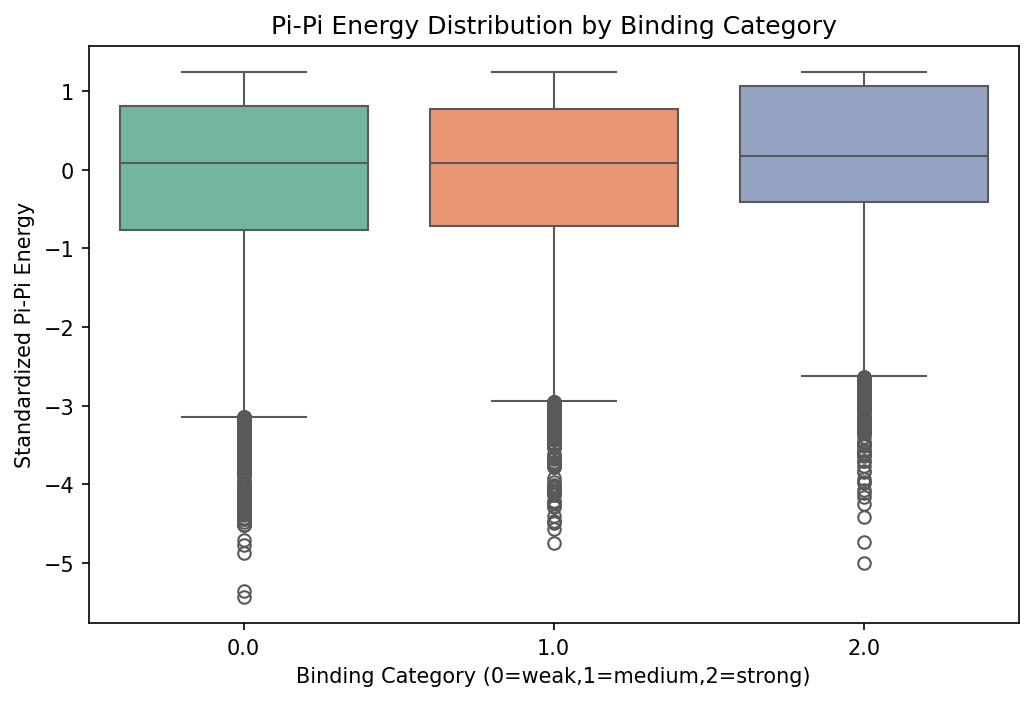

Term: Pi-Pi Energy
 • Avg. bootstrapped KW p-value: 1.951e-02
 • Full KW H-stat=442.03, p-value=1.034e-96, η²=0.006
--------------------------------------------------


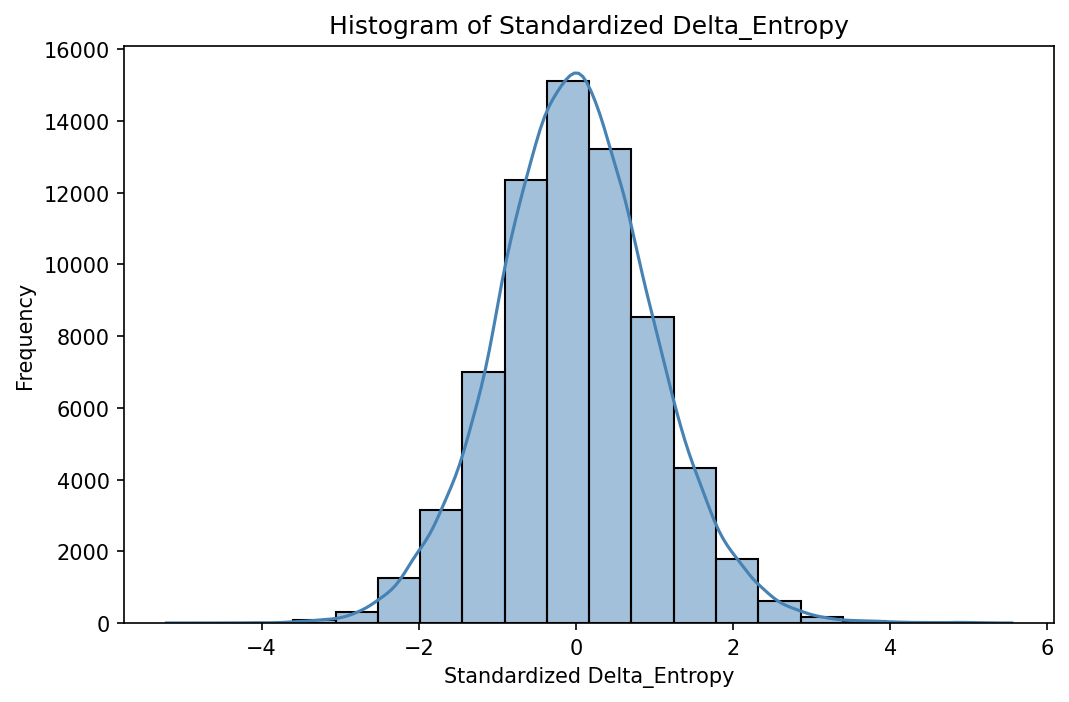

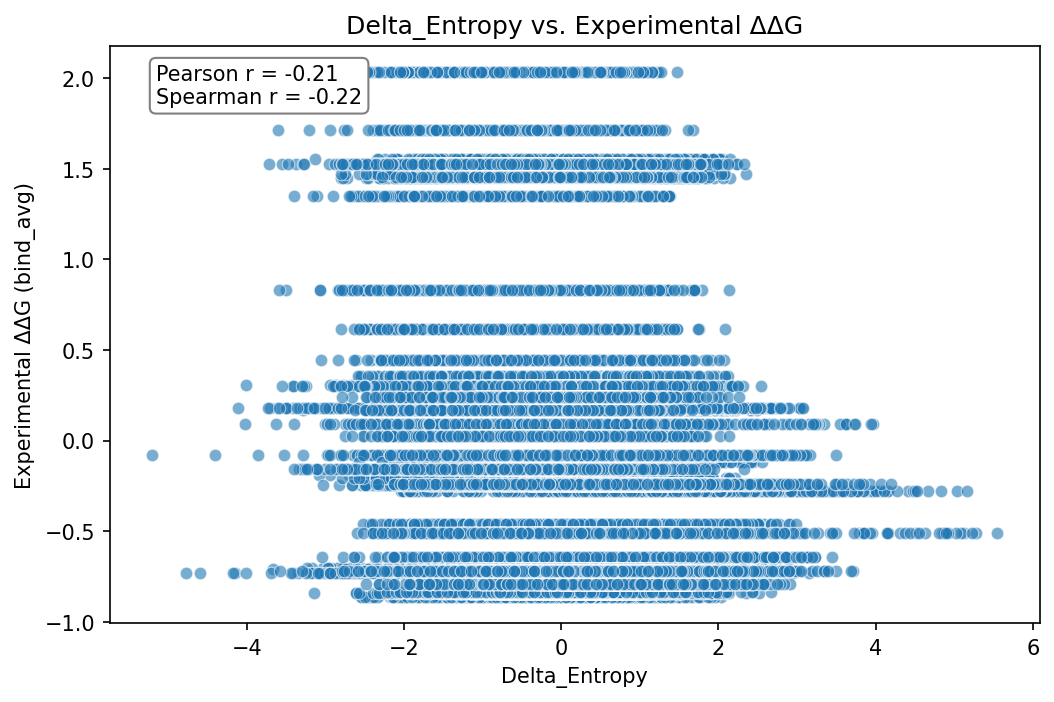

/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_71843/670133172.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")


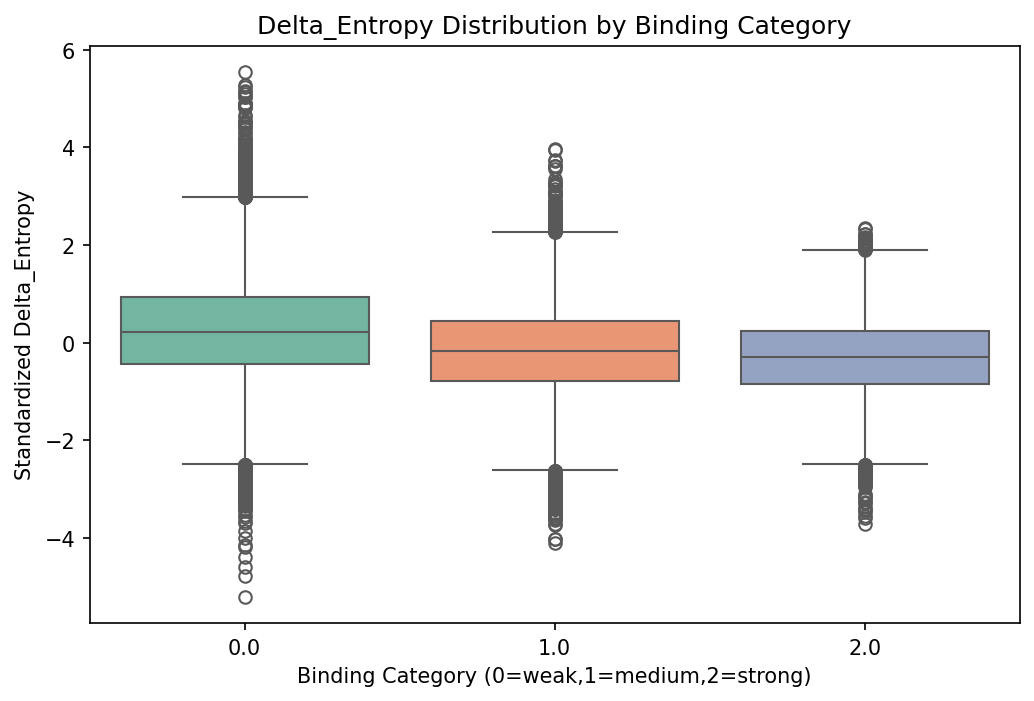

Term: Delta_Entropy
 • Avg. bootstrapped KW p-value: 2.960e-12
 • Full KW H-stat=3981.57, p-value=0.000e+00, η²=0.058
--------------------------------------------------


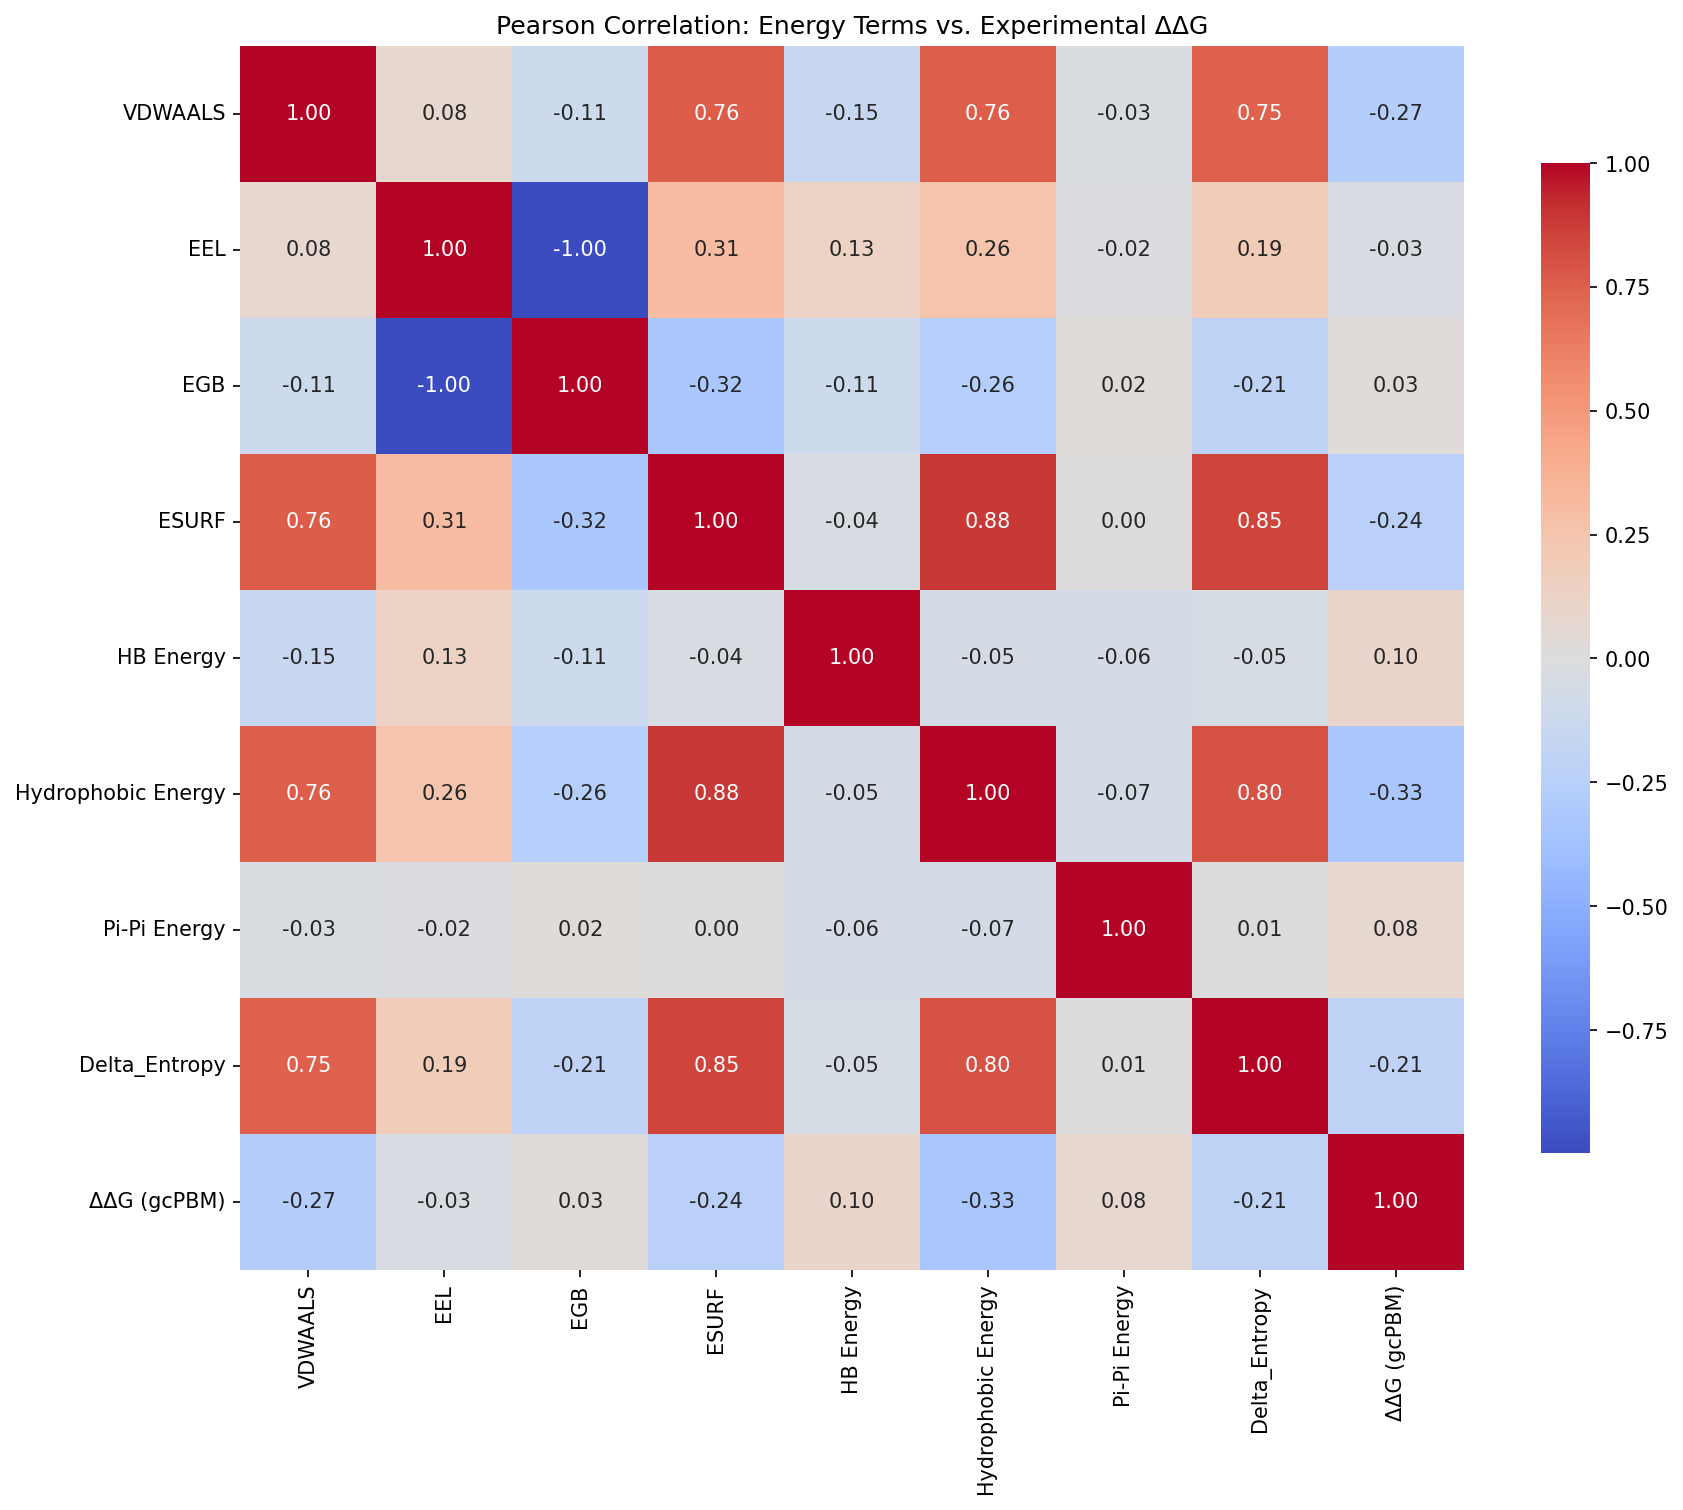

In [9]:
# 1) Load and merge computed vs. experimental data
# ------------------------------------------------
test1 = pd.read_csv("rawdat.csv")  
# Strip off any prefix in the sequence column
test1["sequence"] = test1["sequence"].str.replace("MycMax_", "", regex=False)

test2 = pd.read_csv("exp_data_all.csv")  
# Merge on the 'sequence' key, bringing in bind_avg, binding_type, etc.
df = pd.merge(test1, test2, on="sequence", how="left")

# Drop any sequences without experimental data
df = df.dropna()

# 2) Function to compute η² effect size from Kruskal–Wallis H
# -------------------------------------------------------------
def eta_squared(kruskal_stat, num_groups, total_size):
    """
    Eta-squared estimate of effect size from a KW H-statistic.
      η² = (H - k + 1) / (N - k)
    where k = number of groups, N = total sample size.
    """
    return (kruskal_stat - num_groups + 1) / (total_size - num_groups)

# 3) Loop over each energy term in the computed data
# ---------------------------------------------------
energy_terms = test1.drop(columns=['sequence','run']).columns

for term in energy_terms:
    # a) Standardize this term (zero mean, unit variance)
    std_col = f"{term} (std)"
    df[std_col] = (df[term] - df[term].mean()) / df[term].std()

    # --- 3.1) Histogram of standardized values
    plt.figure(figsize=(8, 5), dpi=150)
    sns.histplot(df[std_col], bins=20, kde=True, color="steelblue")
    plt.xlabel(f"Standardized {term}")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Standardized {term}")
    plt.show()

    # --- 3.2) Scatter vs. bind_avg (with correlation coefficients)
    plt.figure(figsize=(8, 5), dpi=150)
    sns.scatterplot(x=df[std_col], y=df["bind_avg"], alpha=0.6)
    plt.xlabel(term)
    plt.ylabel("Experimental ΔΔG (bind_avg)")
    plt.title(f"{term} vs. Experimental ΔΔG")

    r_pearson, _ = pearsonr(df[std_col], df["bind_avg"])
    r_spearman, _ = spearmanr(df[std_col], df["bind_avg"])
    plt.text(
        0.05, 0.90,
        f"Pearson r = {r_pearson:.2f}\nSpearman r = {r_spearman:.2f}",
        transform=plt.gca().transAxes,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray")
    )
    plt.show()

    # --- 3.3) Boxplot distribution by binding_type (0/1/2 categories)
    plt.figure(figsize=(8, 5), dpi=150)
    sns.boxplot(x=df["binding_type"], y=df[std_col], palette="Set2")
    plt.xlabel("Binding Category (0=weak,1=medium,2=strong)")
    plt.ylabel(f"Standardized {term}")
    plt.title(f"{term} Distribution by Binding Category")
    plt.show()

    # --- 3.4) Bootstrapped Kruskal–Wallis tests
    p_vals = []
    for _ in range(100):
        # sample up to 500 per class to balance
        sampled = df.groupby("binding_type").sample(
            n=min(500, len(df)), 
            random_state=np.random.randint(0,1e6)
        )
        groups = [
            sampled[sampled["binding_type"]==bt][term]
            for bt in sampled["binding_type"].unique()
        ]
        h_stat, p_val = kruskal(*groups)
        p_vals.append(p_val)
    avg_p = np.mean(p_vals)

    # full-dataset Kruskal–Wallis
    full_groups = [
        df[df["binding_type"]==bt][term]
        for bt in df["binding_type"].unique()
    ]
    h_full, p_full = kruskal(*full_groups)
    η2 = eta_squared(h_full, len(full_groups), len(df))

    print(f"Term: {term}")
    print(f" • Avg. bootstrapped KW p-value: {avg_p:.3e}")
    print(f" • Full KW H-stat={h_full:.2f}, p-value={p_full:.3e}, η²={η2:.3f}")
    print("-"*50)

# 4) Correlation Heatmap of all standardized energy terms vs. experimental ΔΔG
# -----------------------------------------------------------------------------
# Build list of standardized columns that exist in df
std_cols = [f"{t} (std)" for t in energy_terms]
cols_for_corr = [c for c in std_cols + ["bind_avg"] if c in df.columns]

# Compute Pearson correlation matrix
corr = df[cols_for_corr].corr(method="pearson")

# Relabel for display
label_map = {c: ("ΔΔG (gcPBM)" if c=="bind_avg" else c.replace(" (std)","")) for c in corr.columns}
corr = corr.rename(columns=label_map, index=label_map)

plt.figure(figsize=(12,10), dpi=150)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Pearson Correlation: Energy Terms vs. Experimental ΔΔG")
plt.tight_layout()
plt.show()

In [10]:
df

sequence  run  VDWAALS       EEL  \
1620    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -236.997 -1869.660   
1621    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -218.620 -1850.331   
1622    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -232.611 -1878.075   
1623    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -203.677 -1870.595   
1624    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -212.279 -1864.730   
...                                      ...  ...      ...       ...   
262435  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -202.283 -1879.826   
262436  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -194.599 -1894.990   
262437  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -201.025 -1877.378   
262438  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -208.522 -1861.670   
262439  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -190.723 -1861.500   

             EGB   ESURF  HB Energy  Hydrophobic Energy  Pi-Pi Energy  \
1620    1823.216 -35.292  -2.590101         -156.445725     -4.282747   
1621    1807.831 -32.521  -2.977171         -142.709472     -7.240534   
1622    1834.181 -34.170  -3.105868         -145.088977     -8.856276   
1623    1823.641 -32.402  -3.414769         -150.961716     -5.338670   
1624    1820.462 -31.858  -3.571942         -146.583284     -7.171679   
...          ...     ...        ...                 ...           ...   
262435  1832.379 -32.929 -14.839736         -146.069103     -8.120329   
262436  1847.186 -32.980 -12.082321         -142.591876     -9.019913   
262437  1832.770 -30.974 -11.361504         -133.609931     -1.746638   
262438  1816.586 -32.079 -16.003776         -139.845659     -0.000942   
262439  1816.467 -31.620 -11.732368         -135.018210     -2.856755   

        Delta_Entropy  ...  binding_type  improving  VDWAALS (std)  EEL (std)  \
1620       -24.750849  ...           1.0        0.0      -1.769420   0.762964   
1621       -25.235404  ...           1.0        0.0      -0.856515   1.265658   
1622       -25.124940  ...           1.0        0.0      -1.551539   0.544114   
1623       -23.079573  ...           1.0        0.0      -0.114198   0.738648   
1624       -22.812241  ...           1.0        0.0      -0.541516   0.891180   
...               ...  ...           ...        ...            ...        ...   
262435     -22.481285  ...           0.0        1.0      -0.044949   0.498575   
262436     -22.615403  ...           0.0        1.0       0.336766   0.104201   
262437     -23.680611  ...           0.0        1.0       0.017544   0.562241   
262438     -21.846114  ...           0.0        1.0      -0.354881   0.970762   
262439     -20.948043  ...           0.0        1.0       0.529312   0.975183   

        EGB (std)  ESURF (std)  HB Energy (std)  Hydrophobic Energy (std)  \
1620    -0.769632    -1.594850         0.920816                 -1.595570   
1621    -1.200774    -0.437331         0.857004                 -0.540648   
1622    -0.462354    -1.126161         0.835787                 -0.723390   
1623    -0.757722    -0.387622         0.784862                 -1.174407   
1624    -0.846809    -0.160379         0.758951                 -0.838151   
...           ...          ...              ...                       ...   
262435  -0.512852    -0.607764        -1.098642                 -0.798662   
262436  -0.097908    -0.629068        -0.644058                 -0.531617   
262437  -0.501895     0.208891        -0.525225                  0.158183   
262438  -0.955428    -0.252696        -1.290544                 -0.320712   
262439  -0.958763    -0.060960        -0.586365                  0.050029   

        Pi-Pi Energy (std)  Delta_Entropy (std)  
1620             -0.411259            -1.382819  
1621             -1.555849            -1.607501  
1622             -2.181102            -1.556280  
1623             -0.819875            -0.607868  
1624             -1.529204            -0.483909  
...                    ...                  ...  
262435           -1.896308            -0.33044

In [11]:
df.to_csv('merged.csv')

In [12]:
# 1) Load and merge computed vs. experimental data
# ------------------------------------------------
test1 = pd.read_csv("rawdat.csv")  
# Strip off any prefix in the sequence column
test1["sequence"] = test1["sequence"].str.replace("MycMax_", "", regex=False)

test2 = pd.read_csv("exp_data_all.csv")  
# Merge on the 'sequence' key, bringing in bind_avg, binding_type, etc.
df = pd.merge(test1, test2, on="sequence", how="left")

# Drop any sequences without experimental data
df = df.dropna()



In [13]:
df

sequence  run  VDWAALS       EEL  \
1620    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -236.997 -1869.660   
1621    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -218.620 -1850.331   
1622    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -232.611 -1878.075   
1623    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -203.677 -1870.595   
1624    CAGGGCTGGGTCCACCTCATGGCCTTTGTTCTGGAA    9 -212.279 -1864.730   
...                                      ...  ...      ...       ...   
262435  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -202.283 -1879.826   
262436  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -194.599 -1894.990   
262437  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -201.025 -1877.378   
262438  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -208.522 -1861.670   
262439  TTAGAACCTCAACCTCCTCTGCAAAATGGAGCTGAC   20 -190.723 -1861.500   

             EGB   ESURF  HB Energy  Hydrophobic Energy  Pi-Pi Energy  \
1620    1823.216 -35.292  -2.590101         -156.445725     -4.282747   
1621    1807.831 -32.521  -2.977171         -142.709472     -7.240534   
1622    1834.181 -34.170  -3.105868         -145.088977     -8.856276   
1623    1823.641 -32.402  -3.414769         -150.961716     -5.338670   
1624    1820.462 -31.858  -3.571942         -146.583284     -7.171679   
...          ...     ...        ...                 ...           ...   
262435  1832.379 -32.929 -14.839736         -146.069103     -8.120329   
262436  1847.186 -32.980 -12.082321         -142.591876     -9.019913   
262437  1832.770 -30.974 -11.361504         -133.609931     -1.746638   
262438  1816.586 -32.079 -16.003776         -139.845659     -0.000942   
262439  1816.467 -31.620 -11.732368         -135.018210     -2.856755   

        Delta_Entropy  bind_avg  binding_type  improving  
1620       -24.750849  0.166339           1.0        0.0  
1621       -25.235404  0.166339           1.0        0.0  
1622       -25.124940  0.166339           1.0        0.0  
1623       -23.079573  0.166339           1.0        0.0  
1624       -22.812241  0.166339           1.0        0.0  
...               ...       ...           ...        ...  
262435     -22.481285 -0.157256           0.0        1.0  
262436     -22.615403 -0.157256           0.0        1.0  
262437     -23.680611 -0.157256           0.0        1.0  
262438     -21.846114 -0.157256           0.0        1.0  
262439     -20.948043 -0.157256           0.0        1.0  

[68040 rows x 13 columns]